<a href="https://colab.research.google.com/github/isaacyeremia/analisis-sentimet-ulasan-review-hotel/blob/main/BiLSTM_dan_DistilBERT_untuk_analisis_sentimen_berdasarkan_ulasan_review_Hotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BiLSTM**

### Upload dan Baca Dataset

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path ke file di Google Drive
file_path = '/content/drive/MyDrive/Hotel_Reviews.csv'

# Baca file CSV
df = pd.read_csv(file_path, delimiter=';')

# Tampilkan nama kolom
print("Nama kolom:", df.columns.tolist())
df.head()

Mounted at /content/drive
Nama kolom: ['Hotel_Name', 'Negative_Review', 'Positive_Review']


,Hotel_Name,Negative_Review,Positive_Review
0,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...
1,Hotel Arena,No Negative,No real complaints the hotel was great great ...
2,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,Hotel Arena,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,Hotel Arena,You When I booked with your company on line y...,Amazing location and building Romantic setting


### Filter dan Label Sentimen Positif/Negatif + Tampilkan Totalnya

In [2]:
# Hapus review kosong
df = df[(df['Negative_Review'] != "No Negative") & (df['Positive_Review'] != "No Positive")]

# Ulasan negatif
neg_df = df[['Negative_Review']].copy()
neg_df.columns = ['review']
neg_df['label'] = 0

# Ulasan positif
pos_df = df[['Positive_Review']].copy()
pos_df.columns = ['review']
pos_df['label'] = 1

# Gabungkan
full_df = pd.concat([neg_df, pos_df], ignore_index=True)

# Tampilkan jumlah total
print(f"Total review positif : {len(pos_df)}")
print(f"Total review negatif : {len(neg_df)}")
print(f"Total keseluruhan     : {len(full_df)}")
full_df.head()

Total review positif : 246238
Total review negatif : 246238
Total keseluruhan     : 492476


,review,label
0,I am so angry that i made this post available...,0
1,Rooms are nice but for elderly a bit difficul...,0
2,My room was dirty and I was afraid to walk ba...,0
3,You When I booked with your company on line y...,0
4,Backyard of the hotel is total mess shouldn t...,0


### Preprocessing Teks

In [3]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# Terapkan
full_df['clean_review'] = full_df['review'].apply(preprocess)
full_df[['clean_review', 'label']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,clean_review,label
0,angry made post available via possible sites u...,0
1,rooms nice elderly bit difficult rooms two sto...,0
2,room dirty afraid walk barefoot floor looked c...,0
3,booked company line showed pictures room thoug...,0
4,backyard hotel total mess happen hotel 4 stars,0


### Tokenisasi dan Padding

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(full_df['clean_review'])

sequences = tokenizer.texts_to_sequences(full_df['clean_review'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = full_df['label'].values

print("Contoh sequence:", sequences[0])
print("Shape X:", X.shape)

Contoh sequence: [3317, 74, 2511, 144, 772, 637, 1033, 107, 1914, 24, 159, 1314, 95, 90, 74, 95, 772, 95, 307, 87, 491, 255, 4, 833, 1467, 2820, 533, 189, 940, 10, 1, 981, 54, 4, 633, 1, 101, 1374, 1557, 59, 492, 3510, 1, 18, 84, 204, 151, 2227, 1, 186, 877, 353, 110, 389, 3105, 1337, 286, 272, 3526, 934, 548, 7976, 296, 106, 309, 1, 2885, 59, 195, 101, 3510, 4420, 1325, 802, 117, 80, 136, 2589, 239, 151, 785, 280, 1, 65, 50, 43, 65, 50, 833, 1669, 367, 38, 1, 128, 136, 3616, 961, 273, 746, 1731, 541, 367, 43, 198, 1, 210, 8173, 40, 1, 80, 266, 1165, 1794, 512, 45, 84, 110, 262, 441, 1, 940, 3117, 2325, 89, 235, 633, 1343, 82, 1, 888, 74, 7750, 2686, 2373, 375, 1343, 700, 4001, 368, 49, 59, 283, 184, 2288, 2716, 654, 7977, 9464, 9837, 253, 1443, 772, 668, 2675, 65, 50, 4025, 268, 295, 8397, 1788, 1779, 472, 280, 309, 1, 4, 828, 101, 163, 1, 196, 24, 497, 721, 3905]
Shape X: (492476, 100)


### Split Data dan Bangun BiLSTM Model

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Tampilkan jumlah data
print("📊 Jumlah Data Split:")
print(f"Train Data   : {X_train.shape[0]}")
print(f"Test Data    : {X_test.shape[0]}")
print(f"Total Data   : {X.shape[0]}")
print(f"Input Shape  : {X.shape[1]}")
print(f"Label Positif (1): {sum(y)}")
print(f"Label Negatif (0): {len(y) - sum(y)}")

# Buat model BiLSTM
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


📊 Jumlah Data Split:
Train Data   : 393980
Test Data    : 98496
Total Data   : 492476
Input Shape  : 100
Label Positif (1): 246238
Label Negatif (0): 246238


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Training Model dan Visualisasi

Epoch 1/5
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - accuracy: 0.9043 - loss: 0.2367 - val_accuracy: 0.9375 - val_loss: 0.1697
Epoch 2/5
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.9392 - loss: 0.1657 - val_accuracy: 0.9392 - val_loss: 0.1682
Epoch 3/5
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.9449 - loss: 0.1518 - val_accuracy: 0.9397 - val_loss: 0.1672
Epoch 4/5
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9483 - loss: 0.1417 - val_accuracy: 0.9394 - val_loss: 0.1713
Epoch 5/5
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9518 - loss: 0.1324 - val_accuracy: 0.9396 - val_loss: 0.1772


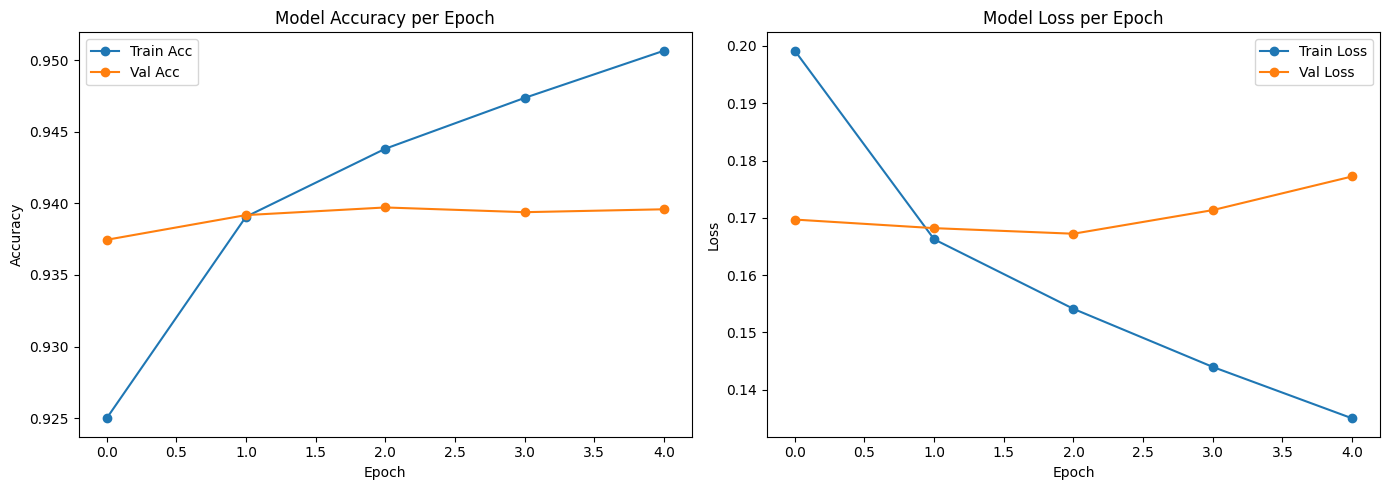


✅ Training selesai. Menampilkan hasil evaluasi:

📈 Final Training Results:
Train Accuracy : 0.9507
Train Loss     : 0.1350
Val Accuracy   : 0.9396
Val Loss       : 0.1772


In [6]:
# 🔁 Training model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# 📊 Ambil nilai akhir dari training & validation
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

# 📈 Visualisasi Accuracy dan Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 🧾 Print hasil evaluasi akhir
print("\n✅ Training selesai. Menampilkan hasil evaluasi:\n")
print("📈 Final Training Results:")
print(f"Train Accuracy : {final_train_acc:.4f}")
print(f"Train Loss     : {final_train_loss:.4f}")
print(f"Val Accuracy   : {final_val_acc:.4f}")
print(f"Val Loss       : {final_val_loss:.4f}")

### Evaluasi Model (Confusion Matrix + Classification Report)

3078/3078 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
📊 Evaluation Metrics:
Accuracy  : 0.9389
Precision : 0.9507
Recall    : 0.9258
F1 Score  : 0.9381


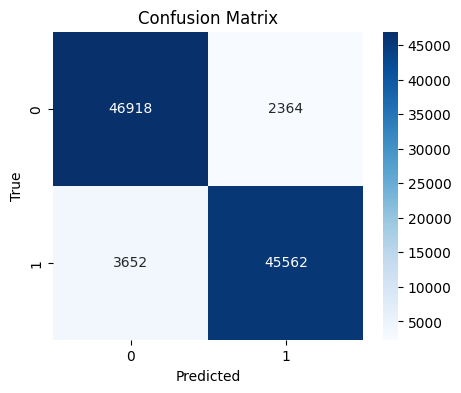


🧾 Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94     49282
    Positive       0.95      0.93      0.94     49214

    accuracy                           0.94     98496
   macro avg       0.94      0.94      0.94     98496
weighted avg       0.94      0.94      0.94     98496



In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

### Simpan Model & Tokenizer

In [8]:
model.save('bilstm_sentiment_model.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("✅ Model dan Tokenizer berhasil disimpan.")

✅ Model dan Tokenizer berhasil disimpan.


### Load Model dan Prediksi Manual

In [9]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load
model = load_model('bilstm_sentiment_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

print("✅ Model dan Tokenizer berhasil di-load!")

# Fungsi prediksi
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return ' '.join(tokens)

def predict_sentiment(text):
    clean = preprocess(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    prob = model.predict(padded)[0][0]
    label = "Positive" if prob > 0.5 else "Negative"
    print(f"\n📝 Review: {text}")
    print(f"🔍 Predicted Sentiment: {label} ({prob:.4f})")

# Coba prediksi input
user_input = input("Masukkan review hotel: ")
predict_sentiment(user_input)

✅ Model dan Tokenizer berhasil di-load!
Masukkan review hotel: Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step

📝 Review: Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge 
🔍 Predicted Sentiment: Negative (0.0506)


# **DistilBERT**

### Install Library

In [10]:
# --- Install Library ---
!pip install transformers
!pip install scikit-learn pandas matplotlib
!pip install nltk

### Import Library

In [11]:
# --- Import Library ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords

### Upload Dataset dari Google Drive

In [12]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Baca Dataset ---
df = pd.read_csv('/content/drive/MyDrive/Hotel_Reviews.csv', sep=';')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Hotel_Name,Negative_Review,Positive_Review
0,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...
1,Hotel Arena,No Negative,No real complaints the hotel was great great ...
2,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,Hotel Arena,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,Hotel Arena,You When I booked with your company on line y...,Amazing location and building Romantic setting


### Preprocessing & Sampling Data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-254174050.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data.groupby('label').apply(lambda x: x.sample(n=10000)).reset_index(drop=True)


Total Review setelah sampling: 20000
Jumlah per Label:
label
0    10000
1    10000
Name: count, dtype: int64


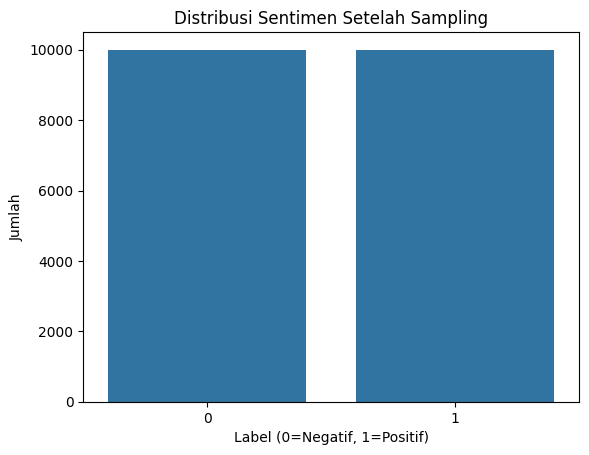

In [13]:
# --- Gabungkan Review Positif & Negatif ---
neg_df = df[df['Negative_Review'] != 'No Negative'][['Negative_Review']].rename(columns={'Negative_Review': 'review'})
neg_df['label'] = 0

pos_df = df[df['Positive_Review'] != 'No Positive'][['Positive_Review']].rename(columns={'Positive_Review': 'review'})
pos_df['label'] = 1

data = pd.concat([neg_df, pos_df]).reset_index(drop=True)

# --- Download stopwords ---
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# --- Clean Text ---
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stop_words])

data['review'] = data['review'].apply(clean_text)

# --- Sampling: 10.000 positif + 10.000 negatif ---
data_sampled = data.groupby('label').apply(lambda x: x.sample(n=10000)).reset_index(drop=True)

# --- Cek jumlah total dan per label ---
print("Total Review setelah sampling:", len(data_sampled))
print("Jumlah per Label:")
print(data_sampled['label'].value_counts())

# --- Visualisasi Distribusi Label ---
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=data_sampled)
plt.title("Distribusi Sentimen Setelah Sampling")
plt.xlabel("Label (0=Negatif, 1=Positif)")
plt.ylabel("Jumlah")
plt.show()

### Tokenisasi & Dataset Class

In [14]:
# --- Load Tokenizer ---
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# --- Dataset Class ---
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=64)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# --- Encode & Split ---
dataset = SentimentDataset(data_sampled['review'].tolist(), data_sampled['label'].tolist())
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

print(f"Train Size: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Train Size: 16000
Test Size: 4000


### Load DistilBERT & Optimizer

In [15]:
# --- Load Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

# --- Optimizer ---
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training & Visualisasi Loss

100%|██████████| 500/500 [01:25<00:00,  5.84it/s]


Epoch 1: Loss = 0.2419, Accuracy = 0.9074


100%|██████████| 500/500 [01:25<00:00,  5.87it/s]


Epoch 2: Loss = 0.1586, Accuracy = 0.9427


100%|██████████| 500/500 [01:24<00:00,  5.94it/s]


Epoch 3: Loss = 0.1176, Accuracy = 0.9591


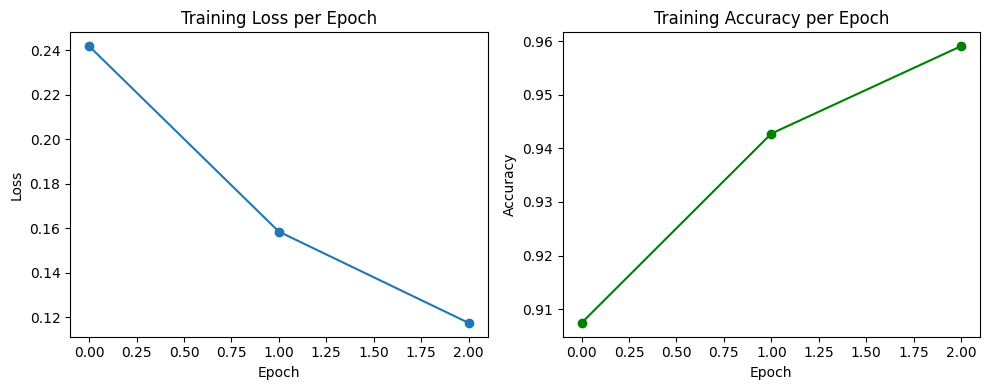

In [16]:
from sklearn.metrics import accuracy_score

# --- Training ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
epochs = 3
losses = []
accuracies = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss
        total_loss += loss.item()

        # Collect predictions & true labels for accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

# --- Plot Loss & Accuracy Curve ---
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Evaluasi Model

100%|██████████| 125/125 [00:07<00:00, 17.72it/s]


Confusion Matrix (Text):
[[1845  154]
 [ 146 1855]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      1999
    Positive       0.92      0.93      0.93      2001

    accuracy                           0.93      4000
   macro avg       0.93      0.92      0.92      4000
weighted avg       0.93      0.93      0.92      4000



<Figure size 600x500 with 0 Axes>

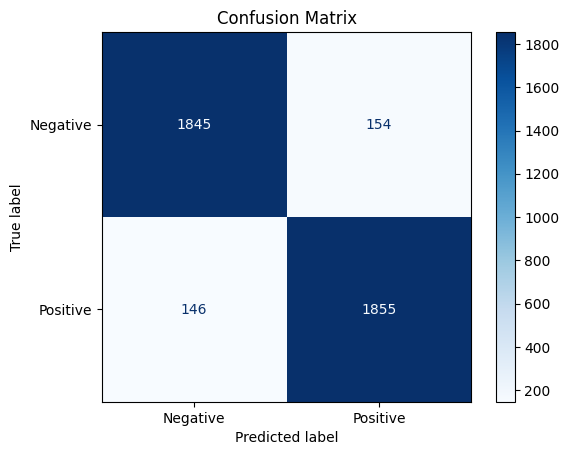

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Evaluation ---
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# --- Print Confusion Matrix (Text)
print("Confusion Matrix (Text):")
print(confusion_matrix(all_labels, all_preds))

# --- Print Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# --- Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Save Model

In [18]:
# --- Save ---
model.save_pretrained("./distilbert_model_v1")
tokenizer.save_pretrained("./distilbert_model_v1")

('./distilbert_model_v1/tokenizer_config.json',
 './distilbert_model_v1/special_tokens_map.json',
 './distilbert_model_v1/vocab.txt',
 './distilbert_model_v1/added_tokens.json')

### Prediksi Manual

In [19]:
# --- Load Model ---
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch, re, nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = DistilBertTokenizer.from_pretrained('./distilbert_model_v1')
model = DistilBertForSequenceClassification.from_pretrained('./distilbert_model_v1').to(device)
model.eval()

# --- Preprocessing ---
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop_words])

# --- Predict ---
def predict_sentiment(text):
    text = preprocess_text(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    label = torch.argmax(outputs.logits, dim=1).item()
    print("Predicted Sentiment:", "Positive" if label == 1 else "Negative")

# --- Manual Test ---
user_input = input("Enter a review: ")
predict_sentiment(user_input)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter a review: Only the park outside of the hotel was beautiful
Predicted Sentiment: Positive
